In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob
import os

In [2]:
sns.set_context("talk")
sns.set_style("ticks")
np.random.seed(1337)

In [3]:
def get_reports_paths(key):
    reports_paths = [
        os.path.realpath(filepath) 
        for filepath in glob(f"../data/active_learning_models/*/*/*/{key}_reports.csv")
    ]
    return reports_paths

def get_reports(report_paths):
    reports = {}
    for filepath in reports_paths:
        *base_path, task, data, model, filename = filepath.split(os.sep)
        key = (task, data, model)
        reports[key] = pd.read_csv(filepath, index_col=[0,1])
    reports = pd.concat(reports, axis=0).rename_axis([
        "task", "data", "model", "round", "label"
    ])
    return reports

In [4]:
MODELS=[
    "random",
    "entropy_top",
    "entropy_proportional",
    "min_margin_top",
    "min_margin_proportional",
]
COLORS = ["0.1", "crimson", "dodgerblue", "crimson", "dodgerblue"]
MARKERS = ["o", "s", "s", "^", "^"]
def plot_reports(reports, split_key, label_key="micro avg", value_key="f1-score", drop_percentile=0):
    for task in reports.index.get_level_values("task").unique():
        data_names = reports.loc[task].index.get_level_values("data").unique()
        ncols = 3
        nrows = np.ceil(len(data_names)/ncols).astype("int")
        width, height = 4, 4
        fig, ax = plt.subplots(
            nrows, ncols, 
            sharex=False, sharey=False,
            figsize=(ncols*width, nrows*height)
        )
        for i, (axi, data) in enumerate(zip(ax.flatten(), data_names)):
            legend=False
            if i == len(data_names)-1:
                legend=True
            df_t = reports.loc[
                (task, data, slice(None), slice(None), label_key), [value_key]
            ].unstack(2).reorder_levels([0,1,3,2], axis=0).xs(
                (task, data, label_key)
            )[value_key].rename(columns={"entropy_random": "random"})
            columns = set(df_t.columns.tolist())
            for model, color, marker in zip(MODELS, COLORS, MARKERS):
                if model not in columns:
                    continue
                df_t.loc[df_t.index > -1, model].plot(
                    marker=marker, color=color, ax=axi, linewidth=1, markersize=2, alpha=0.5
                )
            if df_t[df_t.index == -1].shape[0] == 1:
                axi.axhline(
                    y=df_t[df_t.index == -1].values.mean(), 
                    linestyle="--", color="k", alpha=0.5, lw=1
                )
            if drop_percentile > 0:
                y_low = np.percentile(df_t.loc[df_t.index > -1, model], drop_percentile)
                y_lim = axi.get_ylim()
                axi.set_ylim([y_low, y_lim[1]])
            axi.set_title(data)
        #suptitle = plt.suptitle(task, fontsize=14)
        fig.tight_layout()
        lgd = axi.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
        for lh in lgd.legendHandles:
            lh.set_alpha(1)  # Fixes line alpha
            lh._legmarker.set_markersize(10) # Fixes line marker size
            lh._legmarker.set_alpha(1) # Fixes line marker alpha
        if i < (ncols*nrows - 1):
            for axi in ax.flatten()[i+1:]:
                axi.set_visible(False)
        sns.despine(offset=10)
        plt.savefig(
            f"../figures/active_learning/{task}_{split_key}.pdf", 
            bbox_inches="tight"
        )
        
DEFAULT_LABEL_KEY="micro avg"
DEFAULT_VALUE_KEY="f1-score"
DEFAULT_DROP_PERCENTILE=0

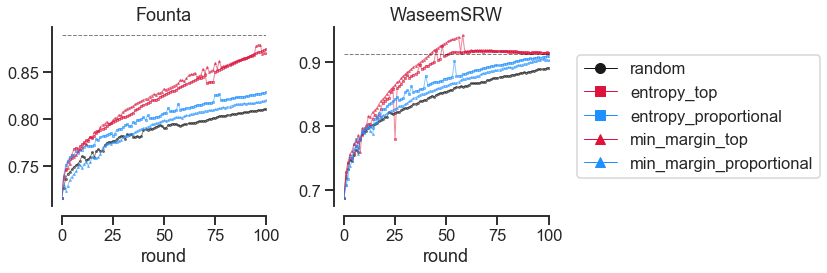

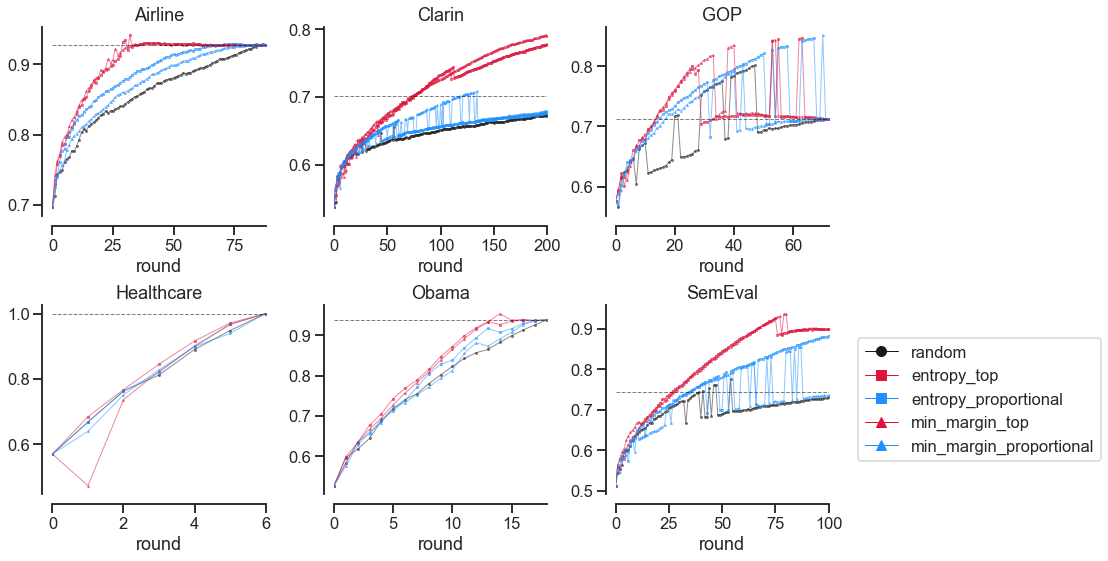

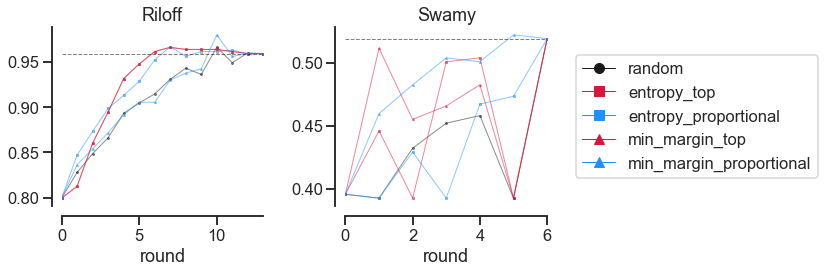

In [5]:
key="train"
reports_paths = get_reports_paths(key)
reports = get_reports(reports_paths)
plot_reports(
    reports, key, label_key=DEFAULT_LABEL_KEY, value_key=DEFAULT_VALUE_KEY, drop_percentile=DEFAULT_DROP_PERCENTILE
)

## Pattern in training data

Above pattern is weird as the performance on full training data is better by using only part of the data compared to using the full training data. See SemEval, Clarin, and GOP. These are all big datasets. 

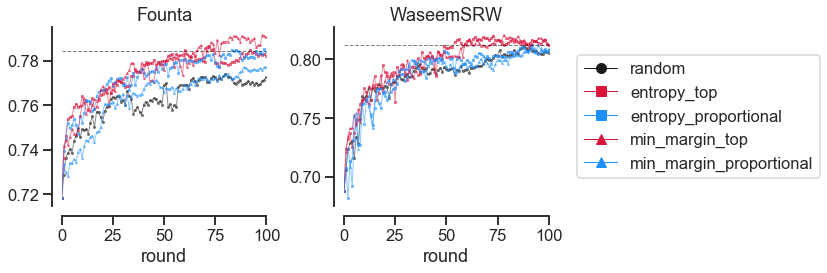

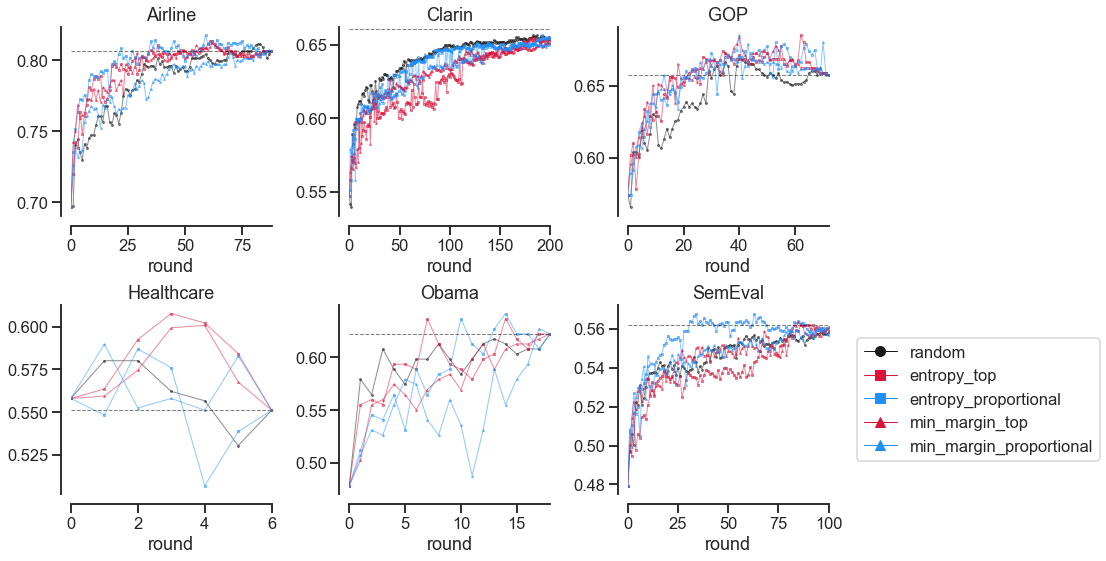

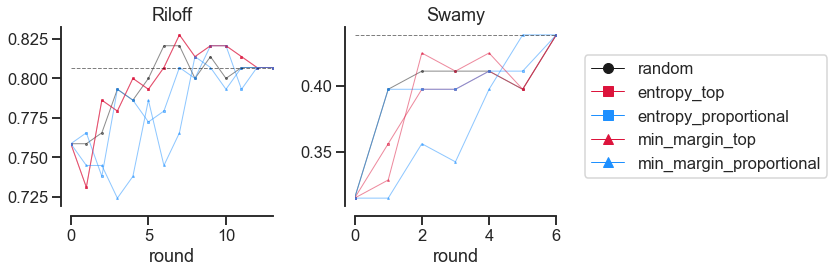

In [6]:
key="dev"
reports_paths = get_reports_paths(key)
reports = get_reports(reports_paths)
plot_reports(
    reports, key, label_key=DEFAULT_LABEL_KEY, value_key=DEFAULT_VALUE_KEY, drop_percentile=DEFAULT_DROP_PERCENTILE
)

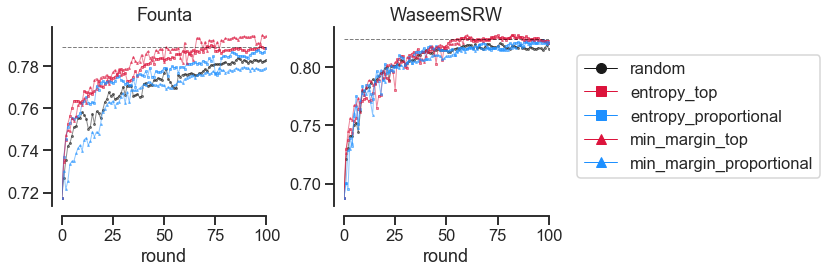

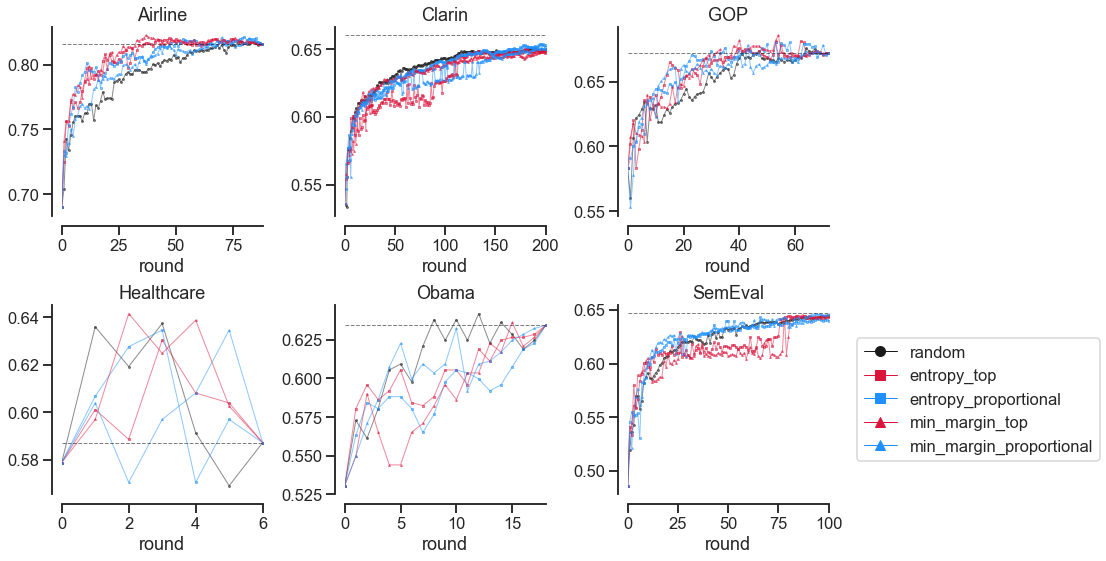

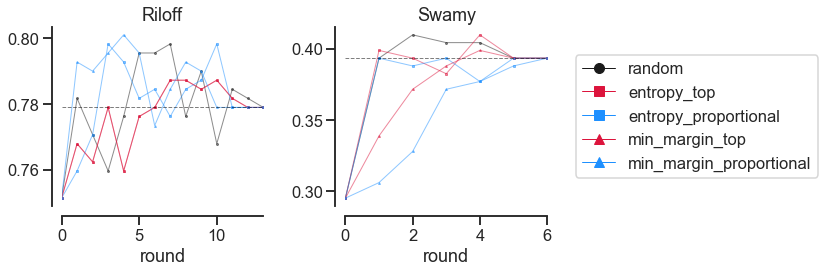

In [7]:
key="test"
reports_paths = get_reports_paths(key)
reports = get_reports(reports_paths)
plot_reports(
    reports, key, label_key=DEFAULT_LABEL_KEY, value_key=DEFAULT_VALUE_KEY, drop_percentile=DEFAULT_DROP_PERCENTILE
)

## The real promise of active learning

Often the question is not about getting a model which is very general
The question is getting quality data, i.e. converting all the data at hand into a quality structured data. 
This is where Active Learning can shine, by being label efficient in converting the unlabeled corpora into a labeled corpora efficiently. The idea is that all the difficult examples can be labeled by humans and the remaining examples are annotated by the machine by using the existing labeled examples. The condition is that the machine should choose what examples the human will label. 

This approach works when the whole data to be annotated is observed and the machine is not expected to perform outside of the distribution of the observed data. 

It is important to note that during active learning we recieve no signal from the dev or test set to update the model or make any choice. All the signals are from the labeled+unlabeled training data only. 

### Evaluating the promise

A good way to evaluate the above hypothesis is to ensure that the selected example are really difficult in some sense, e.g.:

* The features are diverse in the newly selected example in each round compared to the existing set. This can be tested by plotting the increase in vocabulary when new data is added. 
* Another approach is to look at prediction diversity: e.g. histogram of prediction scores or entropy scores across rounds is changing. This is computationally expensive so will be skipped. 

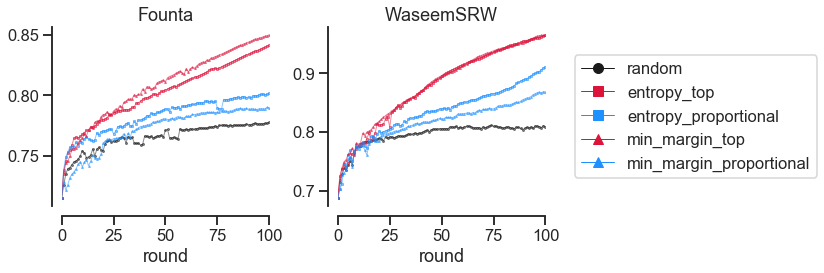

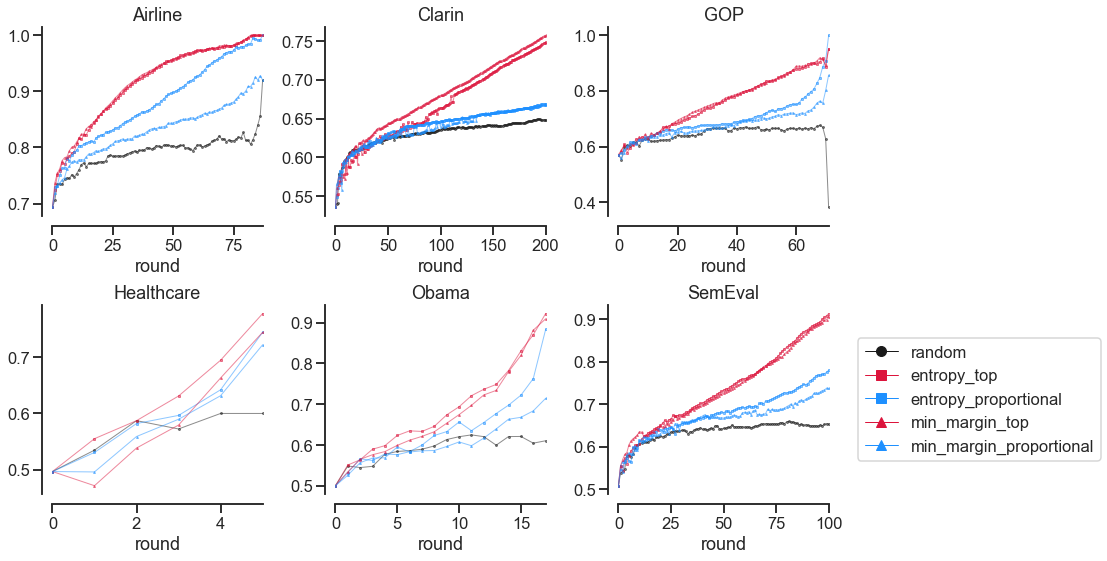

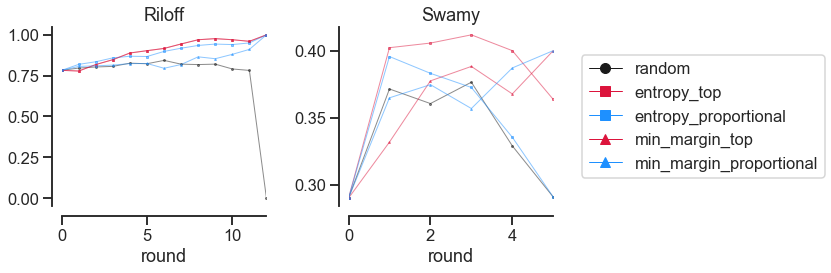

In [8]:
key="unselected"
reports_paths = get_reports_paths(key)
reports = get_reports(reports_paths)
plot_reports(
    reports, key, label_key=DEFAULT_LABEL_KEY, value_key=DEFAULT_VALUE_KEY, drop_percentile=DEFAULT_DROP_PERCENTILE
)